In [ ]:
# Installation of some requirements
# %pip install albumentations
# %pip install ultralytics

In [ ]:
# Kaggle dataset download
# !kaggle datasets download juanthomaswijaya/indonesian-license-plate-dataset --path data --unzip

In [ ]:
# %matplotlib inline

In [1]:
import numpy as np
import torch # If you use PyTorch later for training
import random
import os

# Choose an integer seed (e.g., 42, 0, or any number)
SEED = 42

def set_all_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # If you use PyTorch, uncomment these:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(SEED)

In [15]:
import cv2
import albumentations as A
from glob import glob

# Paths
INPUT_DATA_ROOT = "../data/raw/Indonesian License Plate Dataset/"

input_images = os.path.join(INPUT_DATA_ROOT, "images")
input_labels = os.path.join(INPUT_DATA_ROOT, "labels")

# OUTPUT Paths (A new folder to store the augmented data, usually outside of 'raw')
OUTPUT_DATA_ROOT = "../data/processed/"

output_images = os.path.join(OUTPUT_DATA_ROOT, "images")
output_labels = os.path.join(OUTPUT_DATA_ROOT, "labels")

# --- END: Updated Paths ---

# Create output directories
os.makedirs(output_images, exist_ok=True)
os.makedirs(output_labels, exist_ok=True)

# Define augmentation pipeline
transform = A.Compose([
    A.Rotate(limit=5, p=0.5),
    A.Perspective(scale=(0.02, 0.05)),
    A.RandomBrightnessContrast(p=0.5),
    A.MotionBlur(blur_limit=5, p=0.3),
    A.RandomScale(scale_limit=0.2, p=0.5),
],
bbox_params=A.BboxParams(
    format='yolo', 
    label_fields=['class_labels'],
    # Add clip=True to ensure all coordinates are strictly within [0.0, 1.0]
    clip=True,
    min_area=1.0
))

# Loop through all images
for subdir in os.listdir(input_images):
    # Construct the full paths for the current subdirectory
    current_input_image_dir = os.path.join(input_images, subdir)
    current_input_label_dir = os.path.join(input_labels, subdir)

    # 🛑 FIX 2: Create the corresponding output subdirectories
    current_output_image_dir = os.path.join(output_images, subdir)
    current_output_label_dir = os.path.join(output_labels, subdir)

    os.makedirs(current_output_image_dir, exist_ok=True)
    os.makedirs(current_output_label_dir, exist_ok=True)
    
    print(f"Processing directory: {subdir}")

    # Loop through all images in the subdirectory
    # Using os.path.join is safer than f-string concatenation for paths
    for img_path in glob(os.path.join(current_input_image_dir, "*.jpg")):
        filename = os.path.basename(img_path)
        
        # 🛑 FIX 1: Correctly construct the label path using the subdirectory path
        label_path = os.path.join(current_input_label_dir, filename.replace(".jpg", ".txt"))

        # Safety Check: Ensure the label file exists before proceeding
        if not os.path.exists(label_path):
            print(f"Warning: Label file not found for {filename} in {subdir}. Skipping.")
            continue
            
        # Read image and labels (continue with your original logic)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Error: Could not read image {img_path}. Skipping.")
            continue
            
        h, w, _ = image.shape # This is for context, not strictly needed by the augmentation code

        # ... (rest of the label reading, augmentation, and saving logic) ...

        with open(label_path, "r") as f:
            labels = f.readlines()

        bboxes = []
        class_labels = []
        for label in labels:
            try:
                cls, x, y, bw, bh = map(float, label.strip().split())
                bboxes.append([x, y, bw, bh])
                class_labels.append(int(cls))
            except Exception as e:
                 # Added error handling for malformed lines
                print(f"Error processing label line in {label_path}: {e}. Skipping image.")
                continue

        # Apply transformation
        transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)

        aug_img = transformed['image']
        aug_bboxes = transformed['bboxes']
        aug_labels = transformed['class_labels']

        # 🛑 FIX 2 (Final Save): Save augmented files into the correct OUTPUT subdirectory
        
        # Adding 'aug_' prefix is good practice to distinguish augmented files
        aug_filename = f"aug_{filename}" 

        # Save augmented image
        save_path_img = os.path.join(current_output_image_dir, aug_filename)
        cv2.imwrite(save_path_img, aug_img)

        # Save updated YOLO labels
        save_path_lbl = os.path.join(current_output_label_dir, aug_filename.replace(".jpg", ".txt"))
        with open(save_path_lbl, "w") as f:
            for cls, bbox in zip(aug_labels, aug_bboxes):
                f.write(f"{cls} {' '.join(map(str, bbox))}\n")

print("✅ Data augmentation complete!")


/home/bryan_santosa/conda_envs/torchgpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing directory: test
Processing directory: train
Processing directory: val
✅ Data augmentation complete!


In [16]:
from ultralytics import YOLO
import torch

print("YOLO version:", YOLO._version)
print("CUDA available:", torch.cuda.is_available())
print("Device being used:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


YOLO version: 1
CUDA available: True
Device being used: NVIDIA GeForce RTX 3060 Laptop GPU


In [19]:
DATA_YAML_PATH = '../data.yaml'

target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load a pre-trained YOLOv8-nano model
model = YOLO('yolov8n.pt')

model.model.to(target_device) 

# 3. Verify the change (using the reliable check)
first_param_device = next(model.model.parameters()).device

print("✅ Model device (PyTorch check):", first_param_device)

print("Starting YOLOv8 training...")
results = model.train(
    data=DATA_YAML_PATH,     # Path to the data configuration file
    epochs=40,              # Number of epochs (adjust as needed)
    imgsz=640,               # Input image size (standard for YOLO)
    batch=6,                # Batch size (reduce if you run out of GPU memory)
    name='lp_detection_v3',  # Name for the results folder in 'runs/detect
    # Optional: use the 'freeze' argument if you want to freeze the backbone 
    amp=True,
    device=0,  
    lr0=1e-3
)

print("Training complete. Results saved in runs/detect/lp_detection_v3")

✅ Model device (PyTorch check): cuda:0
Starting YOLOv8 training...
New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.223 🚀 Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937,

In [20]:
evaluate = model.val()

Ultralytics 8.3.223 🚀 Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 1.7±0.1 ms, read: 134.6±15.8 MB/s, size: 1701.0 KB)
val: Scanning /mnt/d/Uni/Semester 5/Computer Vision/Plate-Recognition/data/processed/labels/val.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 119.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.5it/s 4.7s0.4ss
                   all        100        179       0.98      0.961      0.993      0.729
Speed: 8.8ms preprocess, 7.5ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to /mnt/d/Uni/Semester 5/Computer Vision/Plate-Recognition/notebooks/runs/detect/val4


columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
                              0          1          2          3          4
epoch                  1.000000   2.000000   3.000000   4.000000   5.000000
time                  21.254500  39.879400  58.225500  76.807000  94.631500
train/box_loss         1.495820   1.367810   1.340050   1.340440   1.330070
train/cls_loss         2.545190   1.470670   1.236440   1.130550   1.042730
train/dfl_loss         1.142130   1.064740   1.078760   1.048280   1.042080
metrics/precision(B)   0.950420   0.870700   0.957740   0.931430   0.960400
metrics/recall(B)      0.856820   0.827650   0.886350   0.910630   0.948410
metrics/mAP50(B)       0.959420   0.916750   0.957720   0.963430   0.979110
metrics/mAP50-95(B)    0.527450   0.561900   0.585330   0.611060   0.

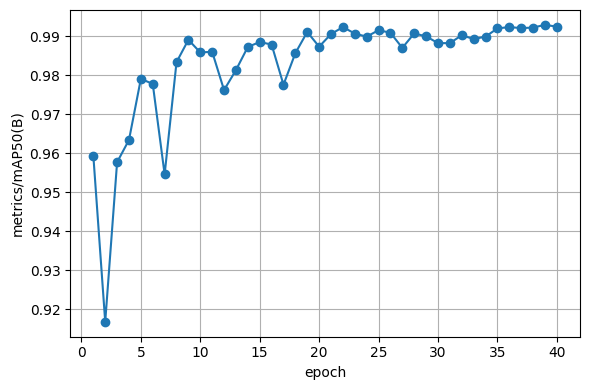

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("runs/detect/lp_detection_v3/results.csv")

# Inspect columns and head to see what's actually in the CSV
print("columns:", df.columns.tolist())
print(df.head().T)

# Pick the mAP column robustly
map_cols = [c for c in df.columns if "mAP50" in c or "map50" in c.lower() or "mAP" in c]
if not map_cols:
    raise ValueError("No mAP column found in results.csv. Columns: " + ", ".join(df.columns))
col = map_cols[0]
print("Using metric column:", col)

# Convert to numeric (coerce errors -> NaN) and warn if any NaNs
y = pd.to_numeric(df[col], errors="coerce")
if y.isnull().any():
    print("Warning: some values in the metric column could not be converted to numeric and became NaN")

# Use epoch column if present else use dataframe index
x = df["epoch"] if "epoch" in df.columns else df.index

plt.figure(figsize=(6,4))
plt.plot(x, y, marker="o")
plt.xlabel("epoch" if "epoch" in df.columns else "index")
plt.ylabel(col)
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
import os
import json
import cv2
from ultralytics import YOLO

YOLO_MODEL_PATH = "./runs/detect/lp_detection_v3/weights/best.pt"
INPUT_DIR = "../data/processed/images/"
OUTPUT_DIR = "../data/cropped/"

os.makedirs(OUTPUT_DIR, exist_ok=True)

model = YOLO(YOLO_MODEL_PATH)

mapping = {}

for class_name in os.listdir(INPUT_DIR):
    input_class_dir = os.path.join(INPUT_DIR, class_name)
    output_class_dir = os.path.join(OUTPUT_DIR, class_name)

    # Create output directory for this class
    os.makedirs(output_class_dir, exist_ok=True)

    for filename in os.listdir(input_class_dir):
        if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        img_path = os.path.join(input_class_dir, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue

        results = model.predict(img, verbose=False)
        boxes = results[0].boxes

        bboxes = boxes.xyxy.cpu().numpy()
        confs = boxes.conf.cpu().numpy()

        cropped_entries = []  # reset for each image

        for i, (x1, y1, x2, y2) in enumerate(bboxes[:, :4]):
            conf = confs[i]
            if conf < 0.5:
                continue

            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            crop = img[y1:y2, x1:x2]

            crop_name = f"{os.path.splitext(filename)[0]}_plate{i+1}.jpg"
            crop_path = os.path.join(output_class_dir, crop_name)

            cv2.imwrite(crop_path, crop)

            cropped_entries.append({
                "crop": crop_name,
                "confidence": float(conf),
                "bbox": [x1, y1, x2, y2]
            })

        if cropped_entries:
            mapping[filename] = cropped_entries

# Save mapping once at the end
mapping_file = os.path.join(OUTPUT_DIR, "detections.json")
with open(mapping_file, "w") as f:
    json.dump(mapping, f, indent=4)

print("Done!")


KeyboardInterrupt: 

In [32]:
import cv2
import numpy as np

def preprocess_for_ocr(img, target_h=32, target_w=128):
    # 1. Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. (Optional) LIGHT denoise — avoid distortion
    # denoised = cv2.fastNlMeansDenoising(gray, h=10)

    # 3. Resize to target OCR input size
    resized = cv2.resize(gray, (target_w, target_h), interpolation=cv2.INTER_AREA)

    return resized


<h1> Preprocess OCR dataset

In [33]:
cropped_OCR_dir = "../data/cropped/"
output_OCR_dir = "../data/trainOCR/images/"

os.makedirs(output_OCR_dir, exist_ok=True)

for dataset_category in os.listdir(cropped_OCR_dir):
    print(full_dataset_category)
    print(os.listdir(cropped_OCR_dir))
    print(dataset_category)
    full_dataset_category = os.path.join(cropped_OCR_dir, dataset_category)
    output_category_dir = os.path.join(output_OCR_dir, dataset_category)
    if not os.path.isdir(full_dataset_category):
        continue
    os.makedirs(output_category_dir, exist_ok=True)
    for filename in os.listdir(full_dataset_category):
        full_cropped_image_path = os.path.join(full_dataset_category, filename)
        full_output_image_path = os.path.join(output_category_dir, filename)

        # --- Load image ---
        img = cv2.imread(full_cropped_image_path)
        if img is None:
            print(f"❌ Cannot read {full_cropped_image_path}, skipping...")
            continue

        # --- Preprocess the image ---
        processed_img = preprocess_for_ocr(img)

        # --- IMPORTANT: Convert to uint8 before saving ---
        processed_img_uint8 = (processed_img * 255).astype("uint8")

        # --- Save the processed image ---
        cv2.imwrite(full_output_image_path, processed_img_uint8)

print("\n🎉 All license plates have been preprocessed for OCR!")

../data/cropped/val
['detections.json', 'test', 'train', 'val']
detections.json
../data/cropped/detections.json
['detections.json', 'test', 'train', 'val']
test
../data/cropped/test
['detections.json', 'test', 'train', 'val']
train
../data/cropped/train
['detections.json', 'test', 'train', 'val']
val

🎉 All license plates have been preprocessed for OCR!


<h1> Training OCR recognition model

<h1>OCR belom bener sama sekali

In [62]:
# ocr_crnn_train.py
import os
import cv2
import math
import json
import time
import torch
import random
import numpy as np
from glob import glob
from typing import List
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Optional fast Levenshtein
try:
    import editdistance
    def levenshtein(a,b): return editdistance.eval(a,b)
except Exception:
    def levenshtein(a, b):
        # simple DP implementation
        la, lb = len(a), len(b)
        dp = list(range(lb+1))
        for i in range(1, la+1):
            prev = dp[:]
            dp[0] = i
            for j in range(1, lb+1):
                dp[j] = min(prev[j] + 1, dp[j-1] + 1, prev[j-1] + (0 if a[i-1]==b[j-1] else 1))
        return dp[lb]

# -------------------------
# User config / paths
# -------------------------
ROOT = "../data/raw/Indonesian License Plate Recognition Dataset"
TARGET_H = 32
TARGET_W = 128   # fixed width (for batching). You can increase if your plates are wide.
BATCH_SIZE = 64
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BEST_MODEL_PATH = "./OCR/best_crnn.pth"


# -------------------------
# Utilities: read classes.names
# -------------------------
def load_classes(path):
    with open(path, "r", encoding="utf-8") as f:
        lines = [l.rstrip("\n") for l in f if l.strip()!=""]
    return lines

# -------------------------
# Build transcription from YOLO character labels
# label line format: "<class_id> <cx> <cy> <w> <h>"
# We sort by cx to get left-to-right reading order.
# -------------------------
def parse_label_file(label_path, class_names):
    chars = []
    try:
        with open(label_path, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                cls = int(parts[0])
                cx = float(parts[1])
                #cy = float(parts[2])
                #w = float(parts[3]); h = float(parts[4])
                chars.append((cx, class_names[cls] if cls < len(class_names) else "?"))
    except FileNotFoundError:
        return ""
    # sort by cx and join
    chars.sort(key=lambda x: x[0])
    transcription = "".join([c for _, c in chars])
    return transcription

# -------------------------
# Dataset
# -------------------------
class PlateOCRDataset(Dataset):

    def __init__(self, root: str, split: str, class_names, transform=None):
        assert split in ("train", "val", "test"), "split must be one of 'train','val','test'"

        self.root = root
        self.split = split
        self.img_dir = os.path.join(root, "images", split)
        self.lbl_dir = os.path.join(root, "labels", split)
        if not os.path.isdir(self.img_dir):
            raise FileNotFoundError(f"Images directory not found: {self.img_dir}")
        if not os.path.isdir(self.lbl_dir):
            # It's OK to allow missing label files per image, but folder should exist
            raise FileNotFoundError(f"Labels directory not found: {self.lbl_dir}")

        # collect image files
        self.files = sorted([
            f for f in os.listdir(self.img_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ])

        self.class_names = class_names
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def _build_label_path(self, image_filename):
        name, _ = os.path.splitext(image_filename)
        return os.path.join(self.lbl_dir, name + ".txt")

    def __getitem__(self, idx):
        filename = self.files[idx]
        img_path = os.path.join(self.img_dir, filename)
        lbl_path = self._build_label_path(filename)

        img = cv2.imread(img_path)
        if img is None:
            raise RuntimeError(f"Failed to read image: {img_path}")

        # --- preprocess (still numpy 2D array H×W) ---
        if self.transform is not None:
            img_proc = self.transform(img)
        else:
            img_proc = img

        # --- convert to tensor CHW ---
        # img_proc shape: (H, W) → (1, H, W)
        img_tensor = torch.from_numpy(img_proc)
        img_tensor = img_tensor.unsqueeze(0) 
        img_tensor = img_tensor.float() / 255.0

        # Build transcription string
        transcription = ""
        if os.path.exists(lbl_path):
            chars = []
            with open(lbl_path, "r") as f:
                for line in f:
                    parts = line.split()
                    if len(parts) < 5:
                        continue
                    cls_id = int(parts[0])
                    cx = float(parts[1])
                    char = self.class_names[cls_id]
                    chars.append((cx, char))
            chars.sort(key=lambda x: x[0])
            transcription = "".join([c for _, c in chars])

        return img_tensor, transcription
    
# -------------------------
# Collate: convert batch of (tensor, str) into
# tensors for CTC: inputs (B, C, H, W), targets concatenated, target_lengths, input_lengths
# We'll encode characters to indices using char2idx mapping.
# -------------------------
def collate_fn(batch, char2idx):
    images = []
    labels = []
    texts = []

    for img, text in batch:
        images.append(img)              # img is already (1,H,W)
        seq = [char2idx[c] for c in text]
        labels.append(seq)
        texts.append(text)

    # Images are already 1xHxW, so we just stack
    images = torch.stack(images).float()

    flat_labels = [x for seq in labels for x in seq]
    targets = torch.tensor(flat_labels, dtype=torch.long)

    target_lengths = torch.tensor([len(seq) for seq in labels], dtype=torch.long)

    input_lengths = torch.full(
        size=(len(batch),),
        fill_value=images.shape[-1] // 4,
        dtype=torch.long
    )

    return images, targets, target_lengths,texts


# -------------------------
# Small CRNN model
# -------------------------
class CRNN(nn.Module):
    def __init__(self, num_chars):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1,64,3,1,1), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,128,3,1,1), nn.ReLU(),
            nn.MaxPool2d((2,1)),

            nn.Conv2d(128,256,3,1,1), nn.ReLU(),
            nn.MaxPool2d((2,1)),

            nn.Conv2d(256,512,3,1,1), nn.ReLU(),
            nn.MaxPool2d((2,1)),

            nn.AdaptiveAvgPool2d((1,None))
        )

        self.linear = nn.Linear(512, 256)
        self.relu   = nn.ReLU()
        self.gru    = nn.GRU(256, 256, num_layers=2, bidirectional=True, batch_first=True)

        self.embedding = nn.Linear(512, num_chars+1)

    def forward(self, x):
        conv = self.cnn(x)
        conv = conv.squeeze(2)        # (B,512,W)
        conv = conv.permute(0,2,1)    # (B,W,512)

        x = self.relu(self.linear(conv))
        x, _ = self.gru(x)
        logits = self.embedding(x)

        return logits.permute(1,0,2)  # (T,B,C)

# -------------------------
# Greedy decode for logits -> string
# -------------------------
def greedy_decode(logits, idx2char):
    probs = torch.softmax(logits, dim=-1)
    max_idx = torch.argmax(probs, dim=-1)

    T, B = max_idx.shape
    blank = len(idx2char)

    results = []

    for b in range(B):
        pred = []
        last = -1
        for t in range(T):
            i = max_idx[t,b].item()
            if i != blank and i != last:
                pred.append(idx2char[i])
            last = i
        results.append("".join(pred))

    return results
# -------------------------
# CER computation
# -------------------------
def cer(preds: List[str], targets: List[str]):
    total_ed = 0
    total_chars = 0
    for p,t in zip(preds, targets):
        total_ed += levenshtein(p, t)
        total_chars += max(1, len(t))
    return total_ed / total_chars



In [64]:
# -------------------------
# Data & Dataloaders
# -------------------------
# load classes
classes_path = os.path.join(ROOT, "classes.names")
class_names = load_classes(classes_path)
# char2idx, idx2char
char2idx = {c:i for i,c in enumerate(class_names)}
idx2char = {i:c for c,i in char2idx.items()}

train_ds = PlateOCRDataset(root=ROOT, split="train", class_names=class_names, transform=preprocess_for_ocr)
val_ds   = PlateOCRDataset(root=ROOT, split="val",   class_names=class_names, transform=preprocess_for_ocr)
test_ds  = PlateOCRDataset(root=ROOT, split="test",  class_names=class_names, transform=preprocess_for_ocr)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda b: collate_fn(b, char2idx))
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda b: collate_fn(b, char2idx))
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda b: collate_fn(b, char2idx))

# -------------------------
# Instantiate model, loss, optimizer
# -------------------------
num_chars = len(class_names)
model = CRNN(num_chars).to(DEVICE)
ctc_loss = nn.CTCLoss(blank=num_chars, zero_infinity=True)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for batch in train_loader:
    images, labels, _,_ = batch
    print("Image batch shape:", images.shape)
    break

# -------------------------
# Training loop (computes input_lengths dynamically)
# -------------------------
def get_input_length(logits_T):  # logits shape T x B x C -> T
    return logits_T.size(0)

best_val_cer = 1.0
for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    epoch_loss = 0.0
    t0 = time.time()
    for images, targets, target_lengths,texts in train_loader:
        # images: (B,1,H,W)
        # targets: 1D tensor of length = sum(target_lengths)
        # target_lengths: (B,)

        # Skip empty-batch targets (no labels in any sample)
        if targets.numel() == 0:
            continue

        images = images.to(DEVICE)
        targets = targets.to(DEVICE)
        target_lengths = target_lengths.to(DEVICE)

        # forward
        logits = model(images)            # (T, B, C)
        T = logits.size(0)
        B = logits.size(1)

        # input_lengths = all T (model produces T timesteps for each sample)
        input_lengths = torch.full((B,), fill_value=T, dtype=torch.long, device=DEVICE)

        # compute CTC loss
        loss = ctc_loss(logits, targets, input_lengths, target_lengths)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_loss += loss.item()

    # validation (unchanged, but ensure you unpack correctly there too)
    model.eval()
    preds = []
    gts = []
    with torch.no_grad():
        for images, targets, target_lengths,texts in val_loader:
            images = images.to(DEVICE)
            logits = model(images)  # T x B x C
            batch_preds = greedy_decode(logits.cpu(), idx2char)
            preds.extend(batch_preds)
            gts.extend(texts)
            # need original strings for gts: we can rebuild strings from targets+target_lengths or
            # change collate to also return texts; easiest: modify collate to return texts as well.
            # For now assume you have access to texts in the val loop (see note below)


    model.eval()
    preds = []
    gts = []
    with torch.no_grad():
        for batch_i, (images, targets, target_lengths, texts) in enumerate(val_loader):
            images = images.to(DEVICE)                           # (B,1,H,W)
            logits = model(images)                              # (T, B, C)
            T, B, C = logits.shape

            # quick checks:
            print(f"\nDEBUG: val batch {batch_i} shapes -> logits: {logits.shape}, targets.len={targets.numel()}, target_lengths.shape={target_lengths.shape}, texts.len={len(texts)}")

            # 1) check that flattened targets length matches sum(target_lengths)
            sum_tlen = int(target_lengths.sum().item()) if target_lengths.numel()>0 else 0
            print("DEBUG: sum(target_lengths) =", sum_tlen, " targets.numel() =", targets.numel())
            if sum_tlen != int(targets.numel()):
                print("WARNING: targets length mismatch! collate_fn flattening is wrong or order mismatch.")

            # 2) greedy decode
            batch_preds = greedy_decode(logits.cpu(), idx2char)   # list of B strings
            for i in range(min(8, B)):
                print(f" SAMP {i}: GT='{texts[i]}'  PRED='{batch_preds[i]}'")

            # 3) check blank probability mass vs char mass for the batch
            probs = torch.softmax(logits, dim=-1)  # T x B x C
            blank_index = len(idx2char)
            blank_probs = probs[:, :, blank_index].mean().item()   # average prob of blank
            char_probs = probs[:, :, :blank_index].mean().item()
            print(f"DEBUG: avg blank prob = {blank_probs:.4f}, avg char prob = {char_probs:.4f}")

            # 4) sanity: reconstruct ground-truth strings from targets+target_lengths to ensure match `texts`
            recon = []
            if targets.numel() > 0:
                # targets is 1D tensor of ints
                start = 0
                for ln in target_lengths.tolist():
                    seq = targets[start:start+ln].cpu().tolist()
                    recon.append("".join([idx2char[idx] for idx in seq]))
                    start += ln
                print("DEBUG: recon[0:4] from targets:", recon[:4])
                # Compare with texts
                for i in range(min(4, len(texts))):
                    if recon[i] != texts[i]:
                        print(f"WARNING: recon[{i}] != texts[{i}] --> '{recon[i]}' != '{texts[i]}'")

            preds.extend(batch_preds)
            gts.extend(texts)

            # only debug first batch
            break

    # compute CER for the partial collected preds/gts
    val_cer_debug = cer(preds, gts)
    print("DEBUG_VAL_CER (first-batch):", val_cer_debug)



Image batch shape: torch.Size([64, 1, 32, 128])

DEBUG: val batch 0 shapes -> logits: torch.Size([64, 64, 37]), targets.len=470, target_lengths.shape=torch.Size([64]), texts.len=64
DEBUG: sum(target_lengths) = 470  targets.numel() = 470
 SAMP 0: GT='B9079FXX'  PRED=''
 SAMP 1: GT='B1950NZG'  PRED=''
 SAMP 2: GT='H9019YC'  PRED=''
 SAMP 3: GT='G7D'  PRED=''
 SAMP 4: GT='AD1067DC'  PRED=''
 SAMP 5: GT='L2905NC'  PRED=''
 SAMP 6: GT='H8011EQ'  PRED=''
 SAMP 7: GT='B1986VMQ'  PRED=''
DEBUG: avg blank prob = 0.9555, avg char prob = 0.0012
DEBUG: recon[0:4] from targets: ['B9079FXX', 'B1950NZG', 'H9019YC', 'G7D']
DEBUG_VAL_CER (first-batch): 1.0

DEBUG: val batch 0 shapes -> logits: torch.Size([64, 64, 37]), targets.len=470, target_lengths.shape=torch.Size([64]), texts.len=64
DEBUG: sum(target_lengths) = 470  targets.numel() = 470
 SAMP 0: GT='B9079FXX'  PRED=''
 SAMP 1: GT='B1950NZG'  PRED=''
 SAMP 2: GT='H9019YC'  PRED=''
 SAMP 3: GT='G7D'  PRED=''
 SAMP 4: GT='AD1067DC'  PRED=''
 SAMP 5: 

KeyboardInterrupt: 

In [ ]:
# -------------------------
# Final test evaluation using best model
# -------------------------
ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()
all_preds, all_gts = [], []
with torch.no_grad():
    for images, texts, targets, target_lengths in test_loader:
        images = images.to(DEVICE)
        logits = model(images)
        preds_batch = greedy_decode(logits.cpu(), idx2char)
        all_preds.extend(preds_batch)
        all_gts.extend(texts)

test_cer = cer(all_preds, all_gts)
print("Final Test CER:", test_cer)


In [10]:
class_names = load_class_names(CLASSES_FILE)
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
